Basic code which shows what it's like to run PPO on the Pistonball env using the parallel API, this code is inspired by CleanRL.

This code is exceedingly basic, with no logging or weights saving.
The intention was for users to have a (relatively clean) ~200 line file to refer to when they want to design their own learning algorithm.

Author: Jet (https://github.com/jjshoots)


Modified by Anthony Goeckner for the patrolling zoo environment.

In [3]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

from gymnasium.spaces.utils import flatten, flatten_space
from patrolling_zoo.patrolling_zoo_v0 import parallel_env, PatrolGraph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Configuration

In [2]:
"""ALGO PARAMS"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ent_coef = 0.1
vf_coef = 0.1
clip_coef = 0.1
gamma = 0.99
batch_size = 1
stack_size = 4
frame_size = (64, 64)
max_cycles = 500
total_episodes = 5

""" ENV SETUP """
patrolGraph = PatrolGraph("patrolling_zoo/env/cumberland.graph")
env = parallel_env(patrolGraph, 3,
    require_explicit_visit=True,
    max_steps=max_cycles
)

/home/xinliangli/miniconda3/envs/patrolling_zoo/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


# Definitions

In [3]:
class Learner(nn.Module):
    def __init__(self, num_actions, num_agents, observation_size):
        super().__init__()

        self.num_actions = num_actions
        self.num_agents = num_agents

        self.network = nn.Sequential(
            # self._layer_init(nn.Conv2d(4, 32, 3, padding=1)),
            # nn.MaxPool2d(2),
            # nn.ReLU(),
            # self._layer_init(nn.Conv2d(32, 64, 3, padding=1)),
            # nn.MaxPool2d(2),
            # nn.ReLU(),
            # self._layer_init(nn.Conv2d(64, 128, 3, padding=1)),
            # nn.MaxPool2d(2),
            # nn.ReLU(),
            # nn.Flatten(),
            self._layer_init(nn.Linear(observation_size, 512)),
            nn.ReLU(),
        )
        self.actor = self._layer_init(nn.Linear(512, num_actions * num_agents), std=0.01)
        self.critic = self._layer_init(nn.Linear(512, 1))

    def _layer_init(self, layer, std=np.sqrt(2), bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)
        return layer

    def get_value(self, x):
        return self.critic(self.network(x / 255.0))

    def get_action_and_value(self, x, action=None):
        hidden = self.network(x / 255.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)


def batchify_obs(obs_space, obs, device):
    """Converts PZ style observations to batch of torch arrays."""
    # convert to list of np arrays
    obs = np.stack([flatten(obs_space, obs[a]) for a in obs], axis=0)
    # convert to torch
    obs = torch.tensor(obs).to(device)

    return obs


def batchify(x, device):
    """Converts PZ style returns to batch of torch arrays."""
    # convert to list of np arrays
    x = np.stack([x[a] for a in x], axis=0)
    # convert to torch
    x = torch.tensor(x).to(device)

    return x


def unbatchify(x, env):
    """Converts np array to PZ style arguments."""
    x = x.cpu().numpy()
    x = {a: x[i] for i, a in enumerate(env.possible_agents)}

    return x

# Setup

In [4]:
num_agents = len(env.possible_agents)
num_actions = env.action_space(env.possible_agents[0]).n
observation_size = flatten_space(env.observation_space(env.possible_agents[0])).shape[0]

""" LEARNER SETUP """
learner = Learner(num_actions=num_actions, num_agents=num_agents, observation_size=observation_size).to(device)
optimizer = optim.Adam(learner.parameters(), lr=0.001, eps=1e-5)

""" ALGO LOGIC: EPISODE STORAGE"""
end_step = 0
total_episodic_return = 0
rb_obs = torch.zeros((max_cycles, num_agents, observation_size)).to(device)
rb_actions = torch.zeros((max_cycles, num_agents)).to(device)
rb_logprobs = torch.zeros((max_cycles, num_agents)).to(device)
rb_rewards = torch.zeros((max_cycles, num_agents)).to(device)
rb_terms = torch.zeros((max_cycles, num_agents)).to(device)
rb_values = torch.zeros((max_cycles, num_agents)).to(device)

# Training

In [5]:
# train for n number of episodes
for episode in range(total_episodes):
    # collect an episode
    with torch.no_grad():
        # collect observations and convert to batch of torch tensors
        next_obs = env.reset(seed=None)
        # reset the episodic return
        total_episodic_return = 0

        # each episode has num_steps
        for step in range(0, max_cycles):
            # rollover the observation
            obs = batchify_obs(env.observation_space(env.possible_agents[0]), next_obs, device)

            # get action from the agent
            actions, logprobs, _, values = learner.get_action_and_value(obs)

            # execute the environment and log data
            next_obs, rewards, terms, truncs, infos = env.step(
                unbatchify(actions, env)
            )

            # add to episode storage
            rb_obs[step] = torch.reshape(obs, (num_agents, observation_size))
            rb_rewards[step] = batchify(rewards, device)
            rb_terms[step] = batchify(terms, device)
            rb_actions[step] = actions
            rb_logprobs[step] = logprobs
            rb_values[step] = values.flatten()

            # compute episodic return
            total_episodic_return += rb_rewards[step].cpu().numpy()

            # if we reach termination or truncation, end
            if any([terms[a] for a in terms]) or any([truncs[a] for a in truncs]):
                end_step = step
                break

    # bootstrap value if not done
    with torch.no_grad():
        rb_advantages = torch.zeros_like(rb_rewards).to(device)
        for t in reversed(range(end_step)):
            delta = (
                rb_rewards[t]
                + gamma * rb_values[t + 1] * rb_terms[t + 1]
                - rb_values[t]
            )
            rb_advantages[t] = delta + gamma * gamma * rb_advantages[t + 1]
        rb_returns = rb_advantages + rb_values

    # convert our episodes to batch of individual transitions
    b_obs = torch.flatten(rb_obs[:end_step], start_dim=0, end_dim=1)
    b_logprobs = torch.flatten(rb_logprobs[:end_step], start_dim=0, end_dim=1)
    b_actions = torch.flatten(rb_actions[:end_step], start_dim=0, end_dim=1)
    b_returns = torch.flatten(rb_returns[:end_step], start_dim=0, end_dim=1)
    b_values = torch.flatten(rb_values[:end_step], start_dim=0, end_dim=1)
    b_advantages = torch.flatten(rb_advantages[:end_step], start_dim=0, end_dim=1)

    # Optimizing the policy and value network
    b_index = np.arange(len(b_obs))
    clip_fracs = []
    for repeat in range(3):
        # shuffle the indices we use to access the data
        np.random.shuffle(b_index)
        for start in range(0, len(b_obs), batch_size):
            # select the indices we want to train on
            end = start + batch_size
            batch_index = b_index[start:end]

            _, newlogprob, entropy, value = learner.get_action_and_value(
                b_obs[batch_index], b_actions.long()[batch_index]
            )
            logratio = newlogprob - b_logprobs[batch_index]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clip_fracs += [
                    ((ratio - 1.0).abs() > clip_coef).float().mean().item()
                ]

            # normalize advantaegs
            advantages = b_advantages[batch_index]
            advantages = (advantages - advantages.mean()) / (
                advantages.std() + 1e-8
            )

            # Policy loss
            pg_loss1 = -b_advantages[batch_index] * ratio
            pg_loss2 = -b_advantages[batch_index] * torch.clamp(
                ratio, 1 - clip_coef, 1 + clip_coef
            )
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            value = value.flatten()
            v_loss_unclipped = (value - b_returns[batch_index]) ** 2
            v_clipped = b_values[batch_index] + torch.clamp(
                value - b_values[batch_index],
                -clip_coef,
                clip_coef,
            )
            v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
            v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
            v_loss = 0.5 * v_loss_max.mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

In [6]:
print(f"Training episode {episode}")
print(f"Episodic Return: {np.mean(total_episodic_return)}")
print(f"Episode Length: {end_step}")
print("")
print(f"Value Loss: {v_loss.item()}")
print(f"Policy Loss: {pg_loss.item()}")
print(f"Old Approx KL: {old_approx_kl.item()}")
print(f"Approx KL: {approx_kl.item()}")
print(f"Clip Fraction: {np.mean(clip_fracs)}")
print(f"Explained Variance: {explained_var.item()}")

Training episode 4
Episodic Return: 309.0
Episode Length: 499

Value Loss: 549.5067138671875
Policy Loss: 37.0327033996582
Old Approx KL: -0.10792922973632812
Approx KL: 0.006039619445800781
Clip Fraction: 0.14562458249833
Explained Variance: 1.1920928955078125e-07


# Evaluation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


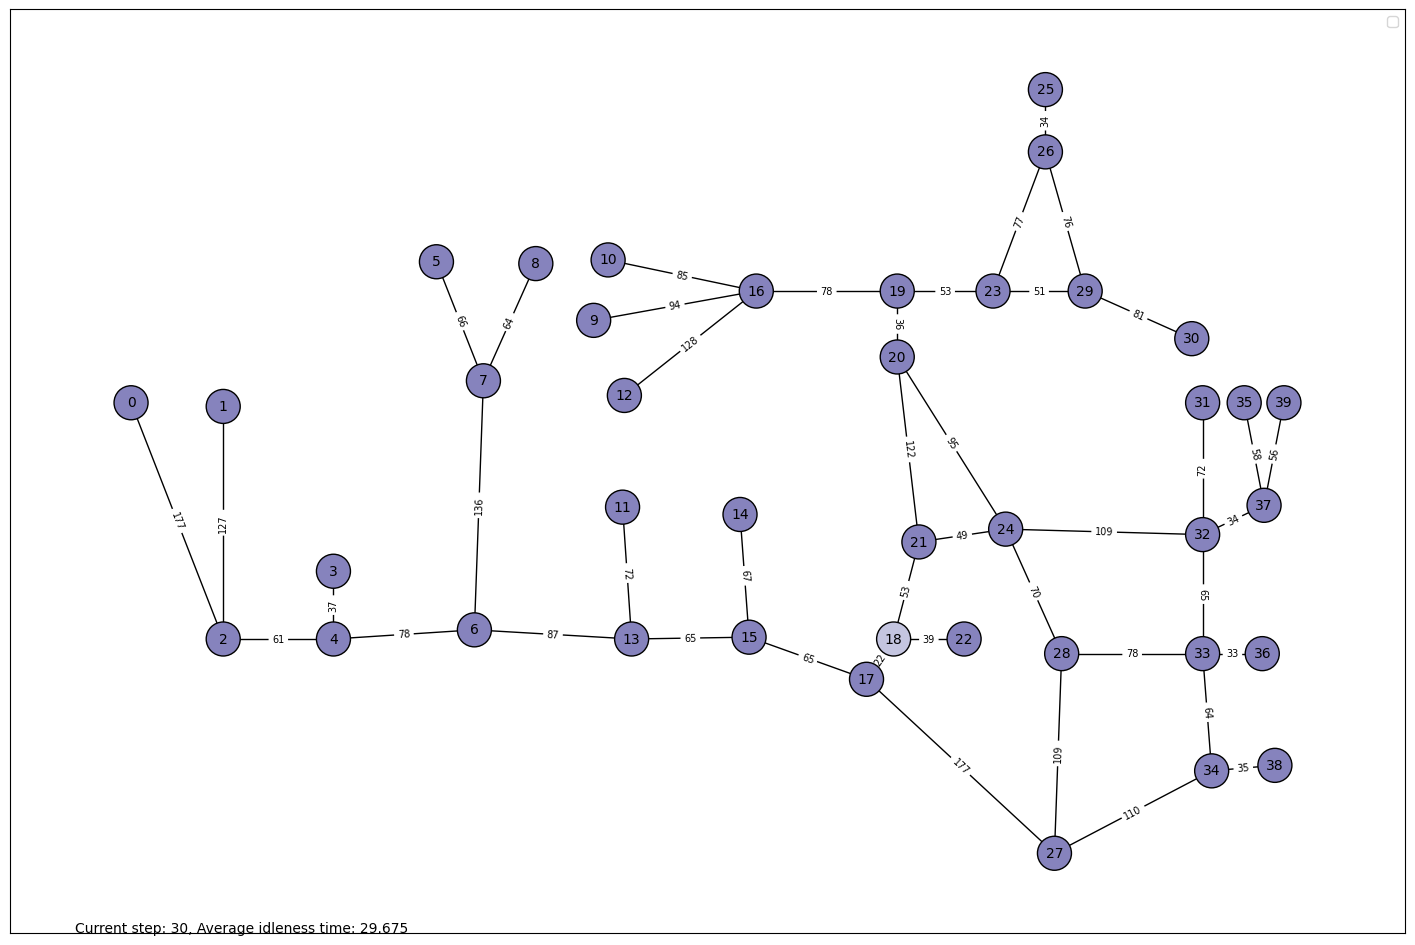

In [7]:
learner.eval()

# TEMP: Only run for 30 steps.
env.maxSteps = 30

with torch.no_grad():
    # render 2 episodes out
    for episode in range(2):
        obs = env.reset(seed=None)
        clear_output(wait=True)
        env.render()
        obs = batchify_obs(env.observation_space(env.possible_agents[0]), obs, device)
        terms = [False]
        truncs = [False]
        while not any(terms) and not any(truncs):
            actions, logprobs, _, values = learner.get_action_and_value(obs)
            obs, rewards, terms, truncs, infos = env.step(unbatchify(actions, env))
            obs = batchify_obs(env.observation_space(env.possible_agents[0]), obs, device)
            terms = [terms[a] for a in terms]
            truncs = [truncs[a] for a in truncs]
            clear_output(wait=True)
            env.render()